# DO ZROBIENIA

- tłumaczenie na angielski wszystkich plików i odwołań do nich tutaj
- przerobienie całego "constants" na słownik config = {} i wszystkie odwołania do stałych przerzucić na takie
- eleganckie po kolei wuywołanie wszystkiego

1. wszystkie stałe, liczby itp do słownika `config` i odwołania w funkcjach
2. funkcje maja być bezargumentowe, oprócz trych które będą udekorowane jako @staticmethod itp. ale to jest zaznaczone
4. jest wywołanie tych funkcji wszystkich w jednej komórce

```python
sales = jakiś dataframe
sales = ogranij_cos_z_sales()

```

In [591]:
import datetime
import os
import random
from itertools import repeat
from pathlib import Path
import itertools
import holidays
import matplotlib.pyplot as plt
import numpy.typing as npt
import numpy as np
import pandas as pd
from faker import Faker
from scipy.stats import expon, gamma, norm, randint, skewnorm, uniform
from unidecode import unidecode_expect_ascii

In [686]:
# constants
staff_number = 6
tournament_number = 20
customers_number = 1500
shop_lifetime_years = 2
traffic_decrease_magnitude = 4
shop_open_hours = {"from": 8, "to": 20, "pick": 17}
traffic_std = 1.5
rental_to_sales_ratio = 0.4
salary_settings = {"minimal": 3530, "exp_scale": 100}
weekday_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
}
staff_shifts = {"morning": [1, 2], "afternoon": [3, 4, 6], "fired": [5]}
shift_hours = 

initial_customer_n = 12
daily_customer_increment = 0.015  # to niech zostanie tyle
weekly_extras_multip = 1
weekly_extras = {
    0: 2,
    1: 1,
    2: 0,
    3: 4,
    4: 5,
    5: 5,
}
phone_num_prefixes = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]

In [687]:

# DODATKOWE ATRYBUTY POTRZEBNE DO LOGIKI !!!!!!!!!!
phone_base = []
email_base = []


### Uwaga, musi być baza telefonów i emaili, bo między customerami i staff też muszą być one różne...

### UWAGI

# Faza 1 - przygotowanie

## Wczytanie csv

In [518]:
def file_path(file_name: str):
    dir_path = [i for i in Path.cwd().parents if i.name == "geeks-and-dragons-db"][0]
    path = os.path.join(dir_path, "config", "prompts", file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError("No such file")

In [519]:
prompt_games = pd.read_csv(file_path("gry.csv"))
prompt_first_names_males = pd.read_csv(file_path("imiona_m.csv"))
prompt_last_names_males = pd.read_csv(file_path("nazwiska_m.csv"))
prompt_first_names_females = pd.read_csv(file_path("imiona_k.csv"))
prompt_last_names_females = pd.read_csv(file_path("nazwiska_k.csv"))
prompt_cities = pd.read_csv(file_path("miasta.csv"))
prompt_emails = pd.read_csv(file_path("Domeny.csv"))
prompt_tournaments = pd.read_csv(file_path("turnieje.csv"), delimiter=";")

## Tabela prompt_dates

In [520]:
def gen_prompt_dates():
    # all the dates
    prompt_dates = pd.DataFrame(
        {
            "date": pd.date_range(
                end=datetime.datetime.now().date(), periods=365 * shop_lifetime_years
            )
        }
    )
    # weekdays
    prompt_dates["weekday"] = prompt_dates["date"].apply(lambda date: date.weekday())
    prompt_dates["weekday_name"] = prompt_dates["weekday"].map(weekday_dict)
    # filtering sundays and holidays
    holidays_pl = holidays.Poland()
    holiday_mask = prompt_dates["date"].apply(lambda date: date in holidays_pl)
    prompt_dates = prompt_dates[(prompt_dates["weekday"] != 6) & ~holiday_mask]
    # adding the base traffic volume
    ### initial numbe
    prompt_dates["volume_base"] = initial_customer_n
    ### a linear trend
    prompt_dates["volume_base"] += (
        np.repeat(daily_customer_increment, prompt_dates.shape[0]).cumsum().round()
    )
    ### additional traffic for each day
    prompt_dates["volume_base"] += (
        prompt_dates["weekday"].map(weekly_extras) * weekly_extras_multip
    )
    # adding sales and rental traffic
    ### sales = base + noise
    prompt_dates["volume_sales"] = (
        prompt_dates["volume_base"]
        + np.random.normal(loc=0, scale=traffic_std, size=prompt_dates.shape[0])
    ).round()
    ### rentals = base * ratio + noise
    prompt_dates["volume_rental"] = (
        prompt_dates["volume_base"] * rental_to_sales_ratio
        + np.random.normal(loc=0, scale=traffic_std, size=prompt_dates.shape[0])
    ).round()

    return prompt_dates

In [521]:
prompt_dates = gen_prompt_dates()

In [522]:
prompt_dates

,date,weekday,weekday_name,volume_base,volume_sales,volume_rental
0,2021-06-30,2,Wednesday,12.0,9.0,5.0
1,2021-07-01,3,Thursday,16.0,14.0,6.0
2,2021-07-02,4,Friday,17.0,17.0,5.0
3,2021-07-03,5,Saturday,17.0,18.0,7.0
5,2021-07-05,0,Monday,14.0,12.0,5.0
...,...,...,...,...,...,...
724,2023-06-24,5,Saturday,26.0,27.0,10.0
726,2023-06-26,0,Monday,23.0,25.0,12.0
727,2023-06-27,1,Tuesday,22.0,22.0,8.0
728,2023-06-28,2,Wednesday,21.0,23.0,9.0


prompt_dates["date"][0]## Tabela prompt_hours

In [523]:
def gen_prompt_hours():
    # list of the hours when opened
    prompt_hours = pd.DataFrame(
        {"hour": np.arange(start=shop_open_hours["from"], stop=shop_open_hours["to"])}
    )
    # traffic increments
    prompt_hours["customer_n"] = np.random.exponential(
        size=prompt_hours.shape[0]
    ).cumsum()
    # traffic decrements after the pick
    decrease_stage = prompt_hours[prompt_hours["hour"] > shop_open_hours["pick"]]
    prompt_hours.loc[decrease_stage.index, "customer_n"] -= np.random.exponential(
        scale=traffic_decrease_magnitude, size=decrease_stage.shape[0]
    ).cumsum()
    # probability column
    prompt_hours["prob"] = prompt_hours["customer_n"] / prompt_hours["customer_n"].sum()
    return prompt_hours

In [525]:
prompt_hours = gen_prompt_hours()

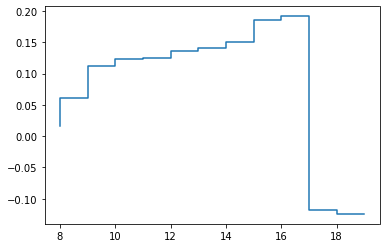

In [526]:
plt.step(range(8, 20), prompt_hours["prob"])

## Gry

In [529]:
def prepar_prompt_games():
    # sample the games but leave the first in csv as the first there
    prompt_games[1:] = prompt_games[1:].sample(frac=1)
    # add the weights
    rng = np.linspace(0, 2, prompt_games["Nazwa"].shape[0])
    expon_curve = expon.pdf(x=rng)
    prompt_games["weights"] = expon_curve / expon_curve.sum()

In [534]:
prepar_prompt_games()

In [535]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,weights
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,Scythe,planszowa,strategiczna,Scythe to gra idealnie łącząca ze sobą mechani...,TAK,289.00,NaN,5.0,0.044128
2,Czarne Historie,karciana,towarzyska,"Czarne historie to zestaw 50 elektryzujących, ...",NIE,30.90,8.0,NaN,0.042363
3,Azul Letni Pawilon,planszowa,logiczna,Gra planszowa Azul: Letni Pawilon przenosi nas...,NIE,159.00,NaN,NaN,0.040669
4,Monopoly Classic,planszowa,familijna,Monopoly Standard to kultowa i znana na całym ...,TAK,115.90,NaN,6.0,0.039043


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [728]:
id_generator = lambda n: [*range(1, n + 1)]


gender_generator = lambda n: random.choices(["M", "F"], weights=[0.5, 0.5], k=n)

# @staticmethod - leave the argument as it is!!!!
@np.vectorize
def _gen_one_phone(*args) -> str:
    while True:
        # get the prefix and the rest of digits
        digits = [
            np.random.choice(phone_num_prefixes),
            *np.random.randint(0, 10, size=7),
        ]
        # concat the digits
        phone = "".join(map(str, digits))
        if not phone in phone_base:
            break
    phone_base.append(phone)
    return phone


# @staticmethod - leave the argument as it is!!!!
@np.vectorize
def _gen_one_name(gender: str, mode: str) -> str:
    # first or last name colname mode
    if mode == "first":
        col = "imię"
        dfs = {"M": prompt_first_names_males, "F": prompt_first_names_females}
    elif mode == "last":
        col = "nazwisko"
        dfs = {"M": prompt_last_names_males, "F": prompt_last_names_females}
    else:
        raise ValueError(f"Cannot generate a name in {mode} mode")
    # random name based on gender and stats
    df = dfs[gender]
    return np.random.choice(df[col], p=df["prob"])


# @staticmethod - leave the argument as it is!!!!
@np.vectorize
def _gen_email(first_name: str, last_name: str) -> str:
    # join the names and cleanse it
    raw_name = f"{first_name.lower()}.{last_name.lower()}"
    cleansed_name = unidecode_expect_ascii(raw_name)
    # initially do not add the number after the name
    number = ""
    while True:
        # concat all the elements
        domain = np.random.choice(prompt_emails["Domena"])
        email = f"{cleansed_name}{number}@{domain}"
        # in the second iteration add the number
        number = np.random.randint(0, 10)
        if not email in email_base:
            break
    email_base.append(email)
    return email


# @staticmethod - leave the argument as it is!!!!
def _gen_staff_to_date() -> npt.NDArray:
    # NULL fill
    dates = np.zeros(staff_number, dtype=np.object_)
    dates[:] = np.nan
    # find the constants
    some_employee_ix = -2
    shop_open_date = prompt_dates["date"].iloc[0]
    today = prompt_dates["date"].iloc[-1]
    # fire him
    dates[some_employee_ix] = Faker().date_between(
        shop_open_date + datetime.timedelta(days=90),
        today - datetime.timedelta(days=90),
    )
    return dates


# @staticmethod - leave the argument as it is!!!!
def _gen_staff_form_date(staff: pd.DataFrame) -> npt.NDArray:
    # hire all of them
    dates = np.zeros(staff_number, dtype=np.object_)
    dates[:] = prompt_dates["date"].iloc[0]
    # hire one with a time shift
    some_employee_ix = -1
    ones_end_date = staff["to_date"].loc[staff["to_date"].isnull() == False].values[0]
    dates[some_employee_ix] = ones_end_date + datetime.timedelta(days=30)
    return dates


def _gen_staff_update_time(staff: pd.DataFrame) -> npt.NDArray:
    df_date = staff[["to_date", "from_date"]]
    return df_date.max(axis=1, skipna=True, numeric_only=False).apply(
        lambda date: date
        + pd.DateOffset(
            hours=random.choice(range(8, 20)),
            minutes=random.choice(range(0, 60)),
            seconds=random.choice(range(0, 60)),
        )
    ) 


# @staticmethod - leave the argument as it is!!!!
def _gen_salary(staff: pd.DataFrame) -> npt.NDArray:
    # over the base salary
    salaries = np.random.exponential(
        scale=salary_settings["exp_scale"],
        size=staff.shape[0],
    )
    # add the base
    salaries += salary_settings["minimal"]
    # round it
    salaries = salaries.round(2)
    # remove the salary for the fired ones
    ix = staff.loc[staff["to_date"].isnull() == False]
    salaries[ix.index] = np.nan
    return salaries

# @staticmethod - leave the argument as it is!!!!
def _gen_manager_status(staff: pd.DataFrame) -> npt.NDArray:
    # on entry no managers
    status = np.full(staff.shape[0], False)
    # the one who has the greatest salary becoms a manager
    ix = staff.loc[staff["current_salary"] == staff["current_salary"].max()]
    status[ix.index] = True
    return status

In [733]:
def staff_df_generator():
    # basic info
    staff = pd.DataFrame(
        {
            "gender": np.random.choice(["M", "F"], size=staff_number),
            "phone": _gen_one_phone(np.zeros(staff_number)),
            "to_date": _gen_staff_to_date(),
        }
    )
    # details
    staff["city"] = np.full(staff.shape[0], "Wrocław")
    staff["from_date"] = _gen_staff_form_date(staff)
    staff["first_name"] = _gen_one_name(staff["gender"], "first")
    staff["last_name"] = _gen_one_name(staff["gender"], "last")
    staff["email"] = _gen_email(staff["first_name"], staff["last_name"])
    staff["current_salary"] = _gen_salary(staff)
    staff["is_manager"] = _gen_manager_status(staff)
    staff["updated_at"] = _gen_staff_update_time(staff)
    # indexing
    staff.sort_values(by=["updated_at"], inplace=True)
    staff["staff_id"] = staff.reset_index()["index"] + 1
    staff = staff.reindex(
        labels=[
            "staff_id",
            "first_name",
            "last_name",
            "phone",
            "email",
            "city",
            "current_salary",
            "is_manager",
            "gender",
            "from_date",
            "to_date",
            "updated_at",
        ],
        axis=1,
    )
    return staff

In [734]:
staff = staff_df_generator()
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
2,1,LEYLA,MIKUŁA,512766785,leyla.mikula@neostrada.pl,Wrocław,4226.72,True,F,2021-06-30,NaN,2021-06-30 13:33:38
3,2,KACPER,WINNIK,885086302,kacper.winnik@tlenofon.pl,Wrocław,3698.65,False,M,2021-06-30,NaN,2021-06-30 16:12:20
0,3,HONORATA,SZCZYGIEŁ,662308974,honorata.szczygiel@tlenofon.pl,Wrocław,3548.87,False,F,2021-06-30,NaN,2021-06-30 17:40:23
1,4,SŁAWOMIR,DOBOSZ,533826022,slawomir.dobosz@vp.pl,Wrocław,3655.32,False,M,2021-06-30,NaN,2021-06-30 18:38:00
4,5,ADRIAN,KOWALIK,788303297,adrian.kowalik@allegro.pl,Wrocław,NaN,False,M,2021-06-30,2022-04-27,2022-04-27 12:07:00
5,6,ANNA,MIKOŁAJCZYK,795646023,anna.mikolajczyk@mail.pl,Wrocław,3561.29,False,F,2022-05-27,NaN,2022-05-27 11:13:49


## Godziny pracy

In [34]:
def gen_weekday_hour_workers():
    hours = pd.DataFrame(
        {"hour": np.arange(shop_open_hours["from"], shop_open_hours["to"])}
    )
    weekdays = pd.DataFrame({"weekday": np.arange(0, 7)})
    pd.merge(hours, weekdays, how="cross")
    if wee

    w = []
    h = []
    for i in hours:
        for j in weekdays:
            w.append(j)
            h.append(i)
    wk = []
    for i in h:
        if i < 14:
            wk.append((1, 2))
        else:
            wk.append((3, 4, 6))

    weekday_hour_worker = pd.DataFrame({"weekday": w, "hour": h, "staff": wk})
    return weekday_hour_worker

In [739]:
weekday_hour_worker = gen_weekday_hour_worker()
weekday_hour_worker

NameError: name 'gen_weekday_hour_worker' is not defined

## Związki

In [36]:
# losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all() == False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [37]:
N = int(np.ceil(staff_number * 1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df["current_salary"].isnull() == False]
    for i in range(n):
        employee = random.choices(
            staff_df.staff_id.values, weights=staff_df.current_salary.values
        )
        staff_id.append(*employee)
        staff_gender.append(
            *staff_df["gender"].loc[staff_df.staff_id == employee[0]].values
        )
        update.append(
            Faker().date_between_dates(
                pd.to_datetime(
                    staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]
                ),
                today,
            )
            + pd.DateOffset(
                hours=random.choice(range(8, 20)),
                minutes=random.choice(range(0, 60)),
                seconds=random.choice(range(0, 60)),
            )
        )
    df = pd.DataFrame(
        {
            "staff_id": staff_id,
            "staff_gender": staff_gender,
            "dates_number": norm_with_condition_generator(n, 5, 2, 0),
            "updated_at": update,
        }
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["relationship_id"] = id_generator(df.shape[0])
    df["partner_id"] = id_generator(df.shape[0])
    df = df.reindex(
        labels=[
            "relationship_id",
            "staff_id",
            "staff_gender",
            "partner_id",
            "dates_number",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [38]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
3,1,3,M,1,3,2021-07-26 11:35:54
1,2,4,M,2,6,2021-08-21 15:24:03
0,3,4,M,3,6,2022-01-07 16:10:26
8,4,2,F,4,7,2022-04-23 09:42:46
6,5,2,F,5,3,2022-07-07 19:01:58
2,6,3,M,6,6,2022-09-22 17:35:45
5,7,6,M,7,8,2022-11-08 17:30:51
4,8,1,M,8,5,2022-11-21 12:48:52
7,9,4,M,9,0,2023-01-30 15:37:42


## Partnerzy

In [39]:
def partners_df_generator(relationships_df):
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == "M":
            gender.append(random.choices(["M", "F"], weights=[0.1, 0.9])[0])
        elif el == "F":
            gender.append(random.choices(["M", "F"], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame(
        {
            "partner_id": partner,
            "gender": gender,
            "updated_at": relationships_df.updated_at,
        }
    )
    partners["name"] = first_name_generator(partners)
    partners.sort_values(by=["updated_at"], inplace=True)
    partners = partners.reindex(
        labels=["partner_id", "name", "gender", "updated_at"], axis=1
    )
    return partners

In [40]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
3,1,ZOFIA,F,2021-07-26 11:35:54
1,2,IRMINA,F,2021-08-21 15:24:03
0,3,ZOFIA,F,2022-01-07 16:10:26
8,4,FILIP,M,2022-04-23 09:42:46
6,5,MACIEJ,M,2022-07-07 19:01:58
2,6,LILIANNA,F,2022-09-22 17:35:45
5,7,WOJCIECH,M,2022-11-08 17:30:51
4,8,ALEKSANDRA,F,2022-11-21 12:48:52
7,9,MIROSŁAWA,F,2023-01-30 15:37:42


## Klienci - część A

In [41]:
customers = pd.DataFrame({"customer_id": id_generator(customers_number)})

## Koszty utrzymania

In [42]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(
        prompt_dates.loc[
            (prompt_dates["date"].dt.day == day)
            | (prompt_dates["date"].dt.day == day + 1),
            "date",
        ]
    )
    base["flag"] = base["date"].dt.to_period("M")
    base.drop_duplicates(["flag"], keep="first", inplace=True)
    base = base.reset_index()
    return base["date"]

In [43]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "CZYNSZ " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": np.full((1, date_df.shape[0]), 3250)[0],
            "type": np.full((1, date_df.shape[0]), "CZYNSZ")[0],
        }
    )
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "ENERGIA ELEKTRYCZNA " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [
                max(round(norm.rvs(150, 4), 2), 100) for i in range(date_df.shape[0])
            ],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def water_generator():
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "WODA " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [
                max(round(norm.rvs(50, 2), 2), 15) for i in range(date_df.shape[0])
            ],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates["date"].dt.day == 5, "date"]
    for j in range(2021, 2024):
        for i in range(4, 11):
            day = datetime.datetime(j, i, 5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "OGRZEWANIE " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [round(norm.rvs(100, 4), 2) for i in range(date_df.shape[0])],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat(
        [staff_df[["first_name", "last_name", "current_salary"]]] * date_df.shape[0],
        ignore_index=True,
    )
    staff_name = staff_df["first_name"].str.cat(staff_df["last_name"], sep=" ")
    names = pd.concat([staff_name] * date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()["date"]
    title_first = dates.dt.month_name(locale="pl_PL").apply(
        lambda x: "PENSJA " + str(x).upper()
    )
    title = title_first.str.cat(names, sep=" ")
    df = pd.DataFrame(
        {
            "date": dates,
            "title": title,
            "amount": all_staff["current_salary"],
            "type": np.full((1, title.shape[0]), "PENSJA")[0],
        }
    )
    to_date = pd.to_datetime(
        staff_df["to_date"].loc[staff_df["to_date"].isnull() == False].values[0]
    )
    df.loc[(df["amount"].isnull() == True) & (df["date"] < to_date), "amount"] = round(
        3490 + expon.rvs(scale=100, loc=80), 2
    )
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame(
        {"date": [], "title": [], "amount": [], "type": [], "updated_at": []}
    )
    df = pd.concat(
        [
            df,
            rent_generator(),
            energy_generator(),
            water_generator(),
            heat_generator(),
            salary_generator(staff),
        ]
    )
    df["updated_at"] = df["date"].apply(
        lambda x: x
        + pd.DateOffset(
            hours=random.choice(range(8, 20)),
            minutes=random.choice(range(0, 60)),
            seconds=random.choice(range(0, 60)),
        )
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["payment_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df["spend_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "spend_id",
            "title",
            "amount",
            "type",
            "date",
            "payment_id",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [44]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,CZYNSZ CZERWIEC,3250.00,CZYNSZ,2021-06-05,1,1,2021-06-05 13:59:42
3,2,WODA CZERWIEC,49.18,MEDIA,2021-06-05,2,2,2021-06-05 15:54:44
3,3,ENERGIA ELEKTRYCZNA CZERWIEC,151.41,MEDIA,2021-06-05,3,3,2021-06-05 19:08:55
2,4,PENSJA CZERWIEC TOMASZ PIKUŁA,3571.46,PENSJA,2021-06-10,4,4,2021-06-10 10:46:10
3,5,PENSJA CZERWIEC RAFAŁ POLIAKOV,3650.02,PENSJA,2021-06-10,5,5,2021-06-10 11:00:29
...,...,...,...,...,...,...,...,...
145,203,PENSJA CZERWIEC DOROTA KAWCZYŃSKA,3619.77,PENSJA,2023-06-10,203,203,2023-06-10 09:33:29
146,204,PENSJA CZERWIEC TOMASZ PIKUŁA,3571.46,PENSJA,2023-06-10,204,204,2023-06-10 11:02:35
147,205,PENSJA CZERWIEC RAFAŁ POLIAKOV,3650.02,PENSJA,2023-06-10,205,205,2023-06-10 11:45:55
144,206,PENSJA CZERWIEC DOMINIK DUDA,3593.14,PENSJA,2023-06-10,206,206,2023-06-10 14:28:16


## Typy wydatków

In [45]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame(
        {"expenses_type": expense_df["type"], "updated_at": expense_df["updated_at"]}
    )
    df.drop_duplicates(subset=["expenses_type"], keep="last", inplace=True)
    df.sort_values(by=["updated_at"], inplace=True)
    df["expenses_type_id"] = id_generator(df.shape[0])
    df = df.reindex(["expenses_type_id", "expenses_type", "updated_at"], axis=1)
    return df

In [46]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,CZYNSZ,2023-06-05 10:36:47
612,2,MEDIA,2023-06-05 19:25:09
149,3,PENSJA,2023-06-10 19:44:36


## Tytuły wydatków

In [47]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame(
        {
            "title": expense_df["title"],
            "expenses_type": expense_df["type"],
            "updated_at": expense_df["updated_at"],
        }
    )
    df.drop_duplicates(subset=["title"], keep="last", inplace=True)
    df = pd.merge(
        df,
        expense_types_df[["expenses_type_id", "expenses_type"]],
        how="left",
        on=["expenses_type"],
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["title_id"] = id_generator(df.shape[0])
    df = df.reindex(["title_id", "title", "expenses_type_id", "updated_at"], axis=1)
    return df

In [48]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA WRZESIEŃ BERNADETA SZYSZKO,3,2021-09-10 16:06:14
1,2,PENSJA PAŹDZIERNIK BERNADETA SZYSZKO,3,2021-10-11 12:34:09
2,3,PENSJA LISTOPAD BERNADETA SZYSZKO,3,2021-11-10 12:04:20
3,4,PENSJA GRUDZIEŃ BERNADETA SZYSZKO,3,2021-12-10 08:52:12
4,5,PENSJA STYCZEŃ BERNADETA SZYSZKO,3,2022-01-10 09:12:30


## Wydatki i tytuły jeszcze raz

In [49]:
maintenance_expenses2 = pd.merge(
    maintenance_expenses, expense_titles[["title_id", "title"]], how="left", on="title"
)
maintenance_expenses2.sort_values(by=["updated_at"], inplace=True)
maintenance_expenses2 = maintenance_expenses2.reindex(
    [
        "spend_id",
        "title_id",
        "type",
        "amount",
        "payment_id",
        "invoice_id",
        "updated_at",
    ],
    axis=1,
)

In [50]:
maintenance_expenses2.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,106,CZYNSZ,3250.00,1,1,2021-06-05 13:59:42
1,2,107,MEDIA,49.18,2,2,2021-06-05 15:54:44
2,3,108,MEDIA,151.41,3,3,2021-06-05 19:08:55
3,4,110,PENSJA,3571.46,4,4,2021-06-10 10:46:10
4,5,111,PENSJA,3650.02,5,5,2021-06-10 11:00:29


## Turnieje

In [58]:
def game_tournament_generator():
    games = prompt_games.loc[
        prompt_games["Turniej"] == "TAK", ["Nazwa", "rodzaj", "kategoria"]
    ]
    tournament_games = pd.merge(
        games,
        prompt_tournaments,
        left_on=["rodzaj", "kategoria"],
        right_on=["Rodzaj", "Kategoria"],
        suffixes=["_gry", "_turnieju"],
    )
    tournament_games = tournament_games[["Nazwa_gry", "Nazwa_turnieju"]]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[
        (weekday_hour_worker["weekday"] == 4)
        & (weekday_hour_worker["hour"] >= 15)
    ]["staff"].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2 ** x
        x -= 1
    return suma

In [59]:
def tournaments_df_generator():
    dates = pd.DataFrame(
        prompt_dates.loc[prompt_dates["weekday"] == 4, "date"].iloc[::6]
    ).reset_index()["date"]
    n = dates.shape[0]
    tournament = game_tournament_generator()
    tournament = tournament.sample(
        n, replace=False, ignore_index=True
    )  # nie może być ten sam wiersz
    tree_levels_number = randint.rvs(2, 4, size=n)
    matches = map(lambda x: count_matches(x), tree_levels_number)
    df = pd.DataFrame(
        {
            "name": tournament["Nazwa_turnieju"],
            "game": tournament["Nazwa_gry"],
            "start_time": dates + datetime.timedelta(hours=15),
            "matches": matches,
            "tree_levels": tree_levels_number,
            "fee": np.full((1, n), 50)[0],
            "sign_up_deadline": dates
            - datetime.timedelta(days=3)
            + datetime.timedelta(hours=20),
            "staff_id": [tournament_staff_generator() for i in range(n)],
            "expenses": map(
                lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=n)
            ),
            "updated_at": dates.apply(
                lambda x: x
                + datetime.timedelta(
                    hours=15,
                    minutes=random.randint(1, 5),
                    seconds=random.randint(1, 59),
                )
            ),
        }
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["tournament_id"] = id_generator(n)
    df["invoice_id"] = id_generator(n)
    df = df.reindex(
        [
            "tournament_id",
            "name",
            "game",
            "start_time",
            "matches",
            "tree_levels",
            "fee",
            "sign_up_deadline",
            "staff_id",
            "expenses",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [60]:
tournaments = tournaments_df_generator()
tournaments.head()

,tournament_id,name,game,start_time,matches,tree_levels,fee,sign_up_deadline,staff_id,expenses,invoice_id,updated_at
0,1,Wrocławski Konwent Planszówkowy,Terraformacja Marsa,2021-06-04 15:00:00,15,3,50,2021-06-01 20:00:00,6,208.53,1,2021-06-04 15:01:39
1,2,Cytadela Strategii,7 Cudów Świata,2021-07-16 15:00:00,7,2,50,2021-07-13 20:00:00,3,221.24,2,2021-07-16 15:01:22
2,3,Wrocławski Festiwal Gier Planszowych,Monopoly Classic,2021-08-27 15:00:00,7,2,50,2021-08-24 20:00:00,6,257.49,3,2021-08-27 15:02:23
3,4,Krucjata Karcianych Mistrzów,Tajniacy,2021-10-08 15:00:00,15,3,50,2021-10-05 20:00:00,4,210.23,4,2021-10-08 15:04:25
4,5,Familijna Rewolucja,Monopoly Classic,2021-11-19 15:00:00,15,3,50,2021-11-16 20:00:00,6,254.19,5,2021-11-19 15:02:54


## Udziały

In [61]:
def sign_up_date_generator(deadline):
    deadline = pd.to_datetime(deadline)
    date = pd.to_datetime(
        prompt_dates["date"]
        .loc[
            (prompt_dates["date"] < deadline)
            & (prompt_dates["date"] > deadline - pd.DateOffset(days=14))
        ]
        .sample(1, ignore_index=True)
        .values[0]
    )
    date += pd.DateOffset(
        hours=random.choice(range(8, 20)),
        minutes=random.choice(range(0, 60)),
        seconds=random.choice(range(0, 60)),
    )
    return date

In [62]:
def participations_df_generator(tournament_df, customers_df):
    # liczba uczestników
    players = pd.merge(
        tournament_df[
            ["game", "tree_levels", "tournament_id", "fee", "sign_up_deadline"]
        ],
        prompt_games[["Nazwa", "Liczba uczestników"]],
        left_on=["game"],
        right_on=["Nazwa"],
        how="left",
    )
    players["Liczba uczestników"] = players["Liczba uczestników"].astype("int")
    players_number = players["Liczba uczestników"] * (2 ** players["tree_levels"])
    players["players"] = players_number

    # customer_id i miejsce
    participants = map(
        lambda x: customers_df["customer_id"]
        .sample(x, replace=False, ignore_index=True)
        .values,
        players_number,
    )
    players["place"] = players["players"].apply(lambda x: [*range(1, x + 1)])
    players["customer_id"] = list(participants)

    # ostateczny df
    df = players[["tournament_id", "customer_id", "fee", "sign_up_deadline", "place"]]
    df = df.explode(["customer_id", "place"], ignore_index=True)
    df["sign_up_date"] = df["sign_up_deadline"].apply(
        lambda x: sign_up_date_generator(x)
    )
    df["updated_at"] = df["sign_up_date"].copy()
    df.sort_values(by=["updated_at"], inplace=True)
    df["particip_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "particip_id",
            "tournament_id",
            "customer_id",
            "place",
            "sign_up_date",
            "fee",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [63]:
participations = participations_df_generator(tournaments, customers)
participations.head()

,particip_id,tournament_id,customer_id,place,sign_up_date,fee,invoice_id,updated_at
28,1,1,1296,29,2021-06-01 08:26:15,50,1,2021-06-01 08:26:15
19,2,1,795,20,2021-06-01 08:30:14,50,2,2021-06-01 08:30:14
13,3,1,693,14,2021-06-01 08:31:19,50,3,2021-06-01 08:31:19
1,4,1,958,2,2021-06-01 08:59:13,50,4,2021-06-01 08:59:13
11,5,1,950,12,2021-06-01 08:59:19,50,5,2021-06-01 08:59:19


## Magazyn

In [64]:
bulk_ratio = 0.5

In [65]:
def get_value_from_another_column(df, search_column, search_value, target_column):
    matching_rows = df.loc[df[search_column] == search_value]
    target_value = matching_rows[target_column].values[0]
    return target_value


def sell():
    N = sum(prompt_dates["volume_sales"]) * expon.rvs(loc=1 / 4)
    while N < 2500 or N > 3700:
        N = sum(prompt_dates["volume_sales"]) * expon.rvs(loc=1 / 4)
    ilość = list(map(round, prompt_games["weights"] * N))
    M = [
        prompt_games["Nazwa"][i : i + 5]
        for i in range(0, len(prompt_games["Nazwa"]), 5)
    ]
    daty = []
    datysklepowe = list(prompt_dates["date"].dt.strftime("%Y-%m-%d"))
    ilość2 = [sum(ilość[i : i + 5]) for i in range(0, 51, 5)]
    for i in range(len(M)):
        d = max(len(M) + round(norm.rvs(0, 5)), 1)
        day = datetime.datetime(
            random.choice(range(2021, 2024)), random.choice(range(1, 13)), d
        ).strftime("%Y-%m-%d")
        while day not in datysklepowe:
            day = datetime.datetime(
                random.choice(range(2021, 2024)), random.choice(range(1, 13)), d
            ).strftime("%Y-%m-%d")
        daty.append(day)
    index = [x for x, y in zip(range(1, len(M) + 1), ilość2) for _ in range(y)]
    indexy = [x for x, y in zip(index, ilość2) for _ in range(y)]
    daty_dost = [x for x, y in zip(daty, ilość2) for _ in range(y)]
    game = [x for x, y in zip(prompt_games["Nazwa"], ilość) for _ in range(y)]
    upd = [
        datetime.datetime.strptime(i, "%Y-%m-%d").replace(
            hour=random.randint(8, 19),
            minute=random.randint(0, 59),
            second=random.randint(0, 59),
        )
        for i in daty_dost
    ]
    ceny = [x for x, y in zip(prompt_games["Kupno"], ilość2) for _ in range(y)]
    df = pd.DataFrame(
        {
            "game": game,
            "destination": ["S" for _ in range(len(indexy))],
            "price": ceny,
            "active": [True for i in range(len(upd))],
            "purchase_payment": [round(bulk_ratio * cena, 2) for cena in ceny],
            "delivery_date": upd,
            "updated_at": upd,
        }
    )
    return df


def rental():
    N = 70
    games_r = [random.choice(prompt_games["Nazwa"]) for i in range(N)]
    daty = ["2021-05-30" for _ in range(N)]
    daty_upd = [
        datetime.datetime.strptime(i, "%Y-%m-%d").replace(
            hour=random.randint(8, 19),
            minute=random.randint(0, 59),
            second=random.randint(0, 59),
        )
        for i in daty
    ]
    df = pd.DataFrame(
        {
            "game": games_r,
            "destination": ["R" for _ in range(N)],
            "price": [
                round(
                    0.1
                    * get_value_from_another_column(
                        prompt_games, "Nazwa", gra, "Kupno"
                    ),
                    2,
                )
                for gra in games_r
            ],
            "active": [True for i in range(N)],
            "purchase_payment": [
                round(
                    bulk_ratio
                    * get_value_from_another_column(
                        prompt_games, "Nazwa", gra, "Kupno"
                    ),
                    2,
                )
                for gra in games_r
            ],
            "delivery_date": daty_upd,
            "updated_at": daty_upd,
        }
    )
    return df


def games_for_tournament(tournaments_df):
    games_amount = (
        tournaments_df[["game", "tree_levels"]]
        .groupby("game")
        .max()
        .apply(lambda x: 2 ** x)
    )
    games = pd.merge(games_amount, prompt_games, left_on=["game"], right_on=["Nazwa"])[
        ["tree_levels", "Nazwa", "Kupno"]
    ]
    n = games.shape[0]
    dates = ["2021-05-30" for _ in range(n)]
    updated = [
        datetime.datetime.strptime(i, "%Y-%m-%d").replace(
            hour=random.randint(8, 19),
            minute=random.randint(0, 59),
            second=random.randint(0, 59),
        )
        for i in dates
    ]
    df = pd.DataFrame(
        {
            "game": games["Nazwa"],
            "destination": ["T" for _ in range(n)],
            "price": [np.nan for i in range(n)],
            "active": [True for i in range(n)],
            "purchase_payment": games["Kupno"],
            "delivery_date": updated,
            "updated_at": updated,
        }
    )
    return df


def inventory_df_generator(tournaments_df):
    sell_df = sell()
    rental_df = rental()
    tournament_df = games_for_tournament(tournaments_df)
    df = pd.concat([sell_df, rental_df, tournament_df])
    df.sort_values(by=["updated_at"], inplace=True)
    df["inventory_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "inventory_id",
            "game",
            "destination",
            "price",
            "active",
            "purchase_payment",
            "invoice_id",
            "delivery_date",
            "updated_at",
        ],
        axis=1,
    )
    df = df.reset_index(drop=True)
    return df

In [66]:
inventory = inventory_df_generator(tournaments)
inventory.head()

,inventory_id,game,destination,price,active,purchase_payment,invoice_id,delivery_date,updated_at
0,1,7 Cudów Świata,T,NaN,True,152.43,1,2021-06-01 08:46:23,2021-06-01 08:46:23
1,2,Mastermind,R,2.62,True,13.10,2,2021-06-01 08:47:25,2021-06-01 08:47:25
2,3,Tajniacy,R,4.99,True,24.95,3,2021-06-01 08:52:36,2021-06-01 08:52:36
3,4,Mistakos,R,4.50,True,22.50,4,2021-06-01 08:55:56,2021-06-01 08:55:56
4,5,"Karty dżentelmenów, Epizod trzeci",R,6.25,True,31.24,5,2021-06-01 08:59:01,2021-06-01 08:59:01


## Ceny gier

In [67]:
def game_prices_df_generator(inventory_df):
    df = inventory_df.drop_duplicates(subset=["price"], keep="last", ignore_index=True)[
        ["price", "updated_at"]
    ]
    df.rename(columns={"price": "current_price"}, inplace=True)
    df = df.sort_values(["updated_at"])
    df["price_id"] = id_generator(df.shape[0])
    df = df.reindex(["price_id", "current_price", "updated_at"], axis=1)
    return df

In [68]:
game_prices = game_prices_df_generator(inventory)
game_prices.head()

,price_id,current_price,updated_at
0,1,8.25,2021-06-01 11:01:37
1,2,4.90,2021-06-01 11:02:28
2,3,4.49,2021-06-01 11:33:42
3,4,1.85,2021-06-01 11:58:34
4,5,15.90,2021-06-01 12:31:49


## Sprzedaże

In [118]:
customer_pcs_probas = {
    1: 0.7,
    2: 0.25,
    3: 0.05,
}

In [196]:
# create vectorized data-related function
v_repeat = np.vectorize(lambda date, volume: itertools.repeat(date, volume))
v_timedelta = np.vectorize(
    lambda h, m, s: datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s))
)
v_get_staff_id = np.vectorize(
    lambda timestamp: np.random.choice(
        weekday_hour_worker.loc[timestamp.weekday()].staff
    )
)
# get a list of dates for each customer
dates_gener = itertools.chain(
    *v_repeat(prompt_dates["date"], prompt_dates["volume_sales"])
)
dates = np.array(list(dates_gener))
# add random time to the date
hours = np.array(
    np.random.choice(hours_prompt["hour"], p=hours_prompt["prob"], size=dates.size)
)
minutes = np.random.randint(0, 59, size=dates.size)
seconds = np.random.randint(0, 59, size=dates.size)
timestamps = dates + v_timedelta(hours, minutes, seconds)
# staff ids
### THIS IS THE MOST TIME CONSUMING LINE
staff = v_get_staff_id(timestamps)
# how many at once are bought
pcs = np.random.choice(
    list(customer_pcs_probas.keys()),
    p=list(customer_pcs_probas.values()),
    size=dates.size,
)
# make a data frame and add invoices as ix
sales = pd.DataFrame({"date": timestamps, "staff_id": staff, "pcs": pcs})
sales = sales.reset_index().rename(columns={"index": "invoice"})
# additional rows when the pieces number is larger than one
for pcs_n in customer_pcs_probas.keys():
    selection = sales[sales["pcs"] == pcs_n]
    sales = pd.concat([sales] + [selection] * (pcs_n - 1))
sales = sales.reset_index(drop=True).drop("pcs", axis="columns")
# pre-filter the inventory table
sales_inventory = inventory_df[(inventory_df["destination"] == "S")]
for i in range(200):
    game_name = np.random.choice(prompt_games["Nazwa"], p=prompt_games["weights"])
    a = sales_inventory[
        # (sales_inventory["game"] == game_name)
        (sales_inventory["active"] == True)
        & (sales_inventory["delivery_date"] < timestamps[i])
    ]["inventory_id"]
    print(timestamps[i])

2021-06-01 14:11:11
2021-06-01 09:37:40
2021-06-01 17:22:08
2021-06-01 10:55:35
2021-06-01 17:00:12
2021-06-01 17:02:53
2021-06-01 16:18:14
2021-06-01 09:06:28
2021-06-01 11:16:07
2021-06-01 12:53:41
2021-06-01 10:49:00
2021-06-01 11:31:43
2021-06-02 14:34:52
2021-06-02 08:22:52
2021-06-02 09:20:25
2021-06-02 09:48:33
2021-06-02 14:07:37
2021-06-02 15:46:07
2021-06-02 11:41:22
2021-06-02 08:06:43
2021-06-02 15:09:26
2021-06-02 12:05:10
2021-06-02 13:20:52
2021-06-02 17:56:06
2021-06-02 17:44:25
2021-06-04 11:04:30
2021-06-04 13:19:42
2021-06-04 08:09:50
2021-06-04 13:38:41
2021-06-04 13:09:32
2021-06-04 15:03:17
2021-06-04 08:08:06
2021-06-04 15:46:10
2021-06-04 16:53:37
2021-06-04 17:47:51
2021-06-04 08:37:35
2021-06-04 15:55:44
2021-06-04 17:15:10
2021-06-04 10:17:01
2021-06-04 14:13:07
2021-06-04 08:06:17
2021-06-04 17:03:22
2021-06-04 14:41:39
2021-06-04 18:29:26
2021-06-05 13:41:58
2021-06-05 17:14:00
2021-06-05 11:25:19
2021-06-05 14:32:25
2021-06-05 15:28:26
2021-06-05 15:24:55


In [183]:
np.random.choice(prompt_games["Nazwa"], p=prompt_games["weights"])

'Story Cubes'

In [65]:
def sales_df_generator(inventory_df):
    all_date = []
    price = []
    invoice = []
    staff = []
    inventory = []
    for j in range(prompt_dates["date"].shape[0]):
        for i in range(prompt_dates["volume_sales"][j]):
            hour = random.choices(
                hours_prompt["hour"], weights=hours_prompt["prob"], k=1
            )[0]
            date = prompt_dates["date"][j] + datetime.timedelta(
                hours=int(hour),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            P = random.choices([1, 2, 3], weights=[0.7, 0.25, 0.05])[0]
            games = random.choices(
                prompt_games["Nazwa"], weights=prompt_games["weights"], k=P
            )
            available_staff = weekday_hour_worker.loc[
                (weekday_hour_worker["weekdays"] == date.day_name(locale="pl_PL"))
                & (weekday_hour_worker["hour"] == date.hour)
            ]["staff"].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            
            for k in games:
                mask = (
                    (inventory_df["game"] == k)
                    & (inventory_df["delivery_date"] < date)
                    & (inventory_df["destination"] == "S")
                    & (inventory_df["active"] == True)
                )
                if mask.any():
                    inventory_df.loc[mask.idxmax(), "active"] = False
                    price.append(inventory_df["price"].loc[mask.idxmax()])
                    all_date.append(date)
                    invoice.append(f"{i}_{j}")
                    staff.append(staff_id)
                    inventory.append(inventory_df["inventory_id"].loc[mask.idxmax()])

    df = pd.DataFrame(
        {
            "inventory_id": inventory,
            "price": price,
            "invoice": invoice,
            "staff_id": staff,
            "date": all_date,
            "return_oper": np.full((1, len(staff)), "False")[0],
            "updated_at": all_date,
        }
    )
    df.sort_values("updated_at", inplace=True)
    df["sale_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "sale_id",
            "inventory_id",
            "staff_id",
            "price",
            "date",
            "invoice",
            "return_oper",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [66]:
sales = sales_df_generator(inventory)

KeyboardInterrupt: 

In [ ]:
sales.head()

## Rentale

In [ ]:
def rental_df_generator(inventory_df):
    rental_date = []
    return_date = []
    customer = []
    price = []
    staff = []
    inventory = []
    rate = []
    update = []
    penalty = []
    invoice = []
    penalty_invoice = []
    for j in range(prompt_dates["date"].shape[0]):
        for i in range(prompt_dates["volume_rental"][j]):
            hour = random.choices(
                hours_prompt["hour"], weights=hours_prompt["prob"], k=1
            )[0]
            date = prompt_dates["date"][j] + datetime.timedelta(
                hours=int(hour),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            P = random.choices([1, 2], weights=[0.7, 0.3])[0]
            games = random.choices(
                prompt_games["Nazwa"], weights=prompt_games["weights"], k=P
            )
            available_staff = weekday_hour_worker.loc[
                (weekday_hour_worker["weekdays"] == date.day_name(locale="pl_PL"))
                & (weekday_hour_worker["hour"] == date.hour)
            ]["staff"].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            holding_time = gamma.rvs(scale=3, a=2)
            return_date_t = prompt_dates["Data"][j] + datetime.timedelta(
                days=int(holding_time),
                hours=round(abs(holding_time) % 1 * 24, 2),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            for k in games:
                mask = (
                    (inventory_df["game"] == k)
                    & (inventory_df["delivery_date"] < date)
                    & (inventory_df["destination"] == "S")
                    & (inventory_df["active"] == True)
                )
                if mask.any():
                    customer.append(int(random.choice(customers["customer_id"])))
                    price.append(inventory_df["price"].loc[mask.idxmax()])
                    rental_date.append(date)
                    staff.append(staff_id)
                    inventory.append(inventory_df["inventory_id"].loc[mask.idxmax()])
                    invoice.append(f"{i}{j}")
                    if return_date_t > datetime.datetime.today():
                        return_date.append(np.nan)
                        update.append(date)
                        inventory_df.loc[mask.idxmax(), "active"] = False
                        penalty.append(np.nan)
                        penalty_invoice.append(np.nan)
                    else:
                        return_date.append(return_date_t)
                        update.append(return_date_t)
                        delta = return_date_t - date
                        if delta.days > 3:
                            penalty.append(
                                0.3
                                * get_value_from_another_column(
                                    prompt_games, "Nazwa", k, "Wypożyczenie"
                                )
                                * delta.days
                            )
                            penalty_invoice.append(f"P{i}_{j}")
                        else:
                            penalty.append(np.nan)
                            penalty_invoice.append(np.nan)
                    rate.append(random.randint(1, 10))

    df = pd.DataFrame(
        {
            "inventory_id": inventory,
            "customer_id": customer,
            "rental_date": rental_date,
            "return_date": return_date,
            "staff_id": staff,
            "price": price,
            "invoice": invoice,
            "penalty_payment": penalty,
            "penalty_invoice": penalty_invoice,
            "rate": rate,
            "updated_at": update,
        }
    )
    df.sort_values("updated_at", inplace=True)
    df["rental_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "rental_id",
            "inventory_id",
            "customer_id",
            "rental_date",
            "return_date",
            "staff_id",
            "price",
            "invoice",
            "penalty_payment",
            "penalty_invoice",
            "rate",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [ ]:
rentals = rental_df_generator(inventory)
rentals.head()

## Gry

In [ ]:
def games_df_generator(inventory_df):
    update = inventory_df[["game", "delivery_date"]].groupby(["game"]).min()
    games = pd.merge(prompt_games, update, left_on=["Nazwa"], right_on=["game"])
    games = games[["Nazwa", "opis", "kategoria", "rodzaj", "Turniej", "delivery_date"]]
    games.rename(
        columns={
            "Nazwa": "title",
            "opis": "description",
            "kategoria": "category",
            "rodzaj": "type",
            "Turniej": "competitivity",
            "delivery_date": "updated_at",
        },
        inplace=True,
    )
    games["competitivity"] = games["competitivity"].apply(
        lambda x: True if x == "TAK" else False
    )
    games.sort_values(["updated_at"], inplace=True)
    games["game_id"] = id_generator(games.shape[0])
    games = games.reindex(
        [
            "game_id",
            "title",
            "description",
            "category",
            "type",
            "competitivity",
            "updated_at",
        ],
        axis=1,
    )
    return games

In [ ]:
games = games_df_generator(inventory)
games.head()

## Katrgorie gier i typy gier

In [ ]:
def game_categories_df_generator(games_df):
    df = games_df[["category", "updated_at"]].drop_duplicates("category", keep="first")
    df.rename(columns={"category": "game_category"}, inplace=True)
    df["category_id"] = id_generator(df.shape[0])
    df = df.reindex(["category_id", "game_category", "updated_at"], axis=1)
    return df

In [ ]:
game_categories = game_categories_df_generator(games)
game_categories

In [ ]:
games["category"] = games["category"].map(
    dict(zip(game_categories["game_category"], game_categories["category_id"]))
)

--------

In [ ]:
def game_types_df_generator(games_df):
    df = games_df[["type", "updated_at"]].drop_duplicates("type", keep="first")
    df.rename(columns={"type": "game_type"}, inplace=True)
    df["type_id"] = id_generator(df.shape[0])
    df = df.reindex(["type_id", "game_type", "updated_at"], axis=1)
    return df

In [ ]:
game_types = game_types_df_generator(games)
game_types

In [ ]:
games["type"] = games["type"].map(
    dict(zip(game_types["game_type"], game_types["type_id"]))
)

## Klienci - część B

In [ ]:
def customers_drop(customers, rentals, participations):
    for i in customers["customer_id"]:
        if (
            i not in rentals["customer_id"].values
            and i not in participations["customer_id"].values
        ):
            customers = customers.drop(customers[customers["customer_id"] == i].index)
    return customers

In [ ]:
customers = customers_drop(customers, rentals, participations)
customers

In [ ]:
merged_df = pd.concat([participations, rentals])

In [ ]:
rentals

In [ ]:
merged_df["updated_at"] = pd.to_datetime(merged_df["updated_at"])
merged_df = merged_df.groupby("customer_id")["updated_at"].min().reset_index()
customers["updated_at"] = list(merged_df["updated_at"])
customers.sort_values(["updated_at"], inplace=True)
temp = dict(zip(customers["customer_id"], id_generator(len(customers["customer_id"]))))
customers["customer_id"] = id_generator(len(customers["customer_id"]))
rentals["customer_id"] = rentals["customer_id"].map(temp)
participations["customer_id"] = participations["customer_id"].map(temp)

In [ ]:
prompt_cities

In [ ]:
def customers_df_generator(customers):
    n = len(customers["customer_id"])
    customers["gender"] = [*gender_generator(n)]
    customers["phone"] = [*phone_generator(n)] # uwaga, musi być inny niż istnieje!!
    customers["city"] = [
        random.choices(prompt_cities["miasto"], weights=prompt_cities["prob"])[0]
        for i in range(n)
    ]
    customers["first_name"] = first_name_generator(customers)
    customers["last_name"] = last_name_generator(customers)
    email_generator(customers)
    customers = customers[
        [
            "customer_id",
            "first_name",
            "last_name",
            "phone",
            "email",
            "city",
            "updated_at",
        ]
    ]
    return customers

In [ ]:
customers = customers_df_generator(customers)
customers

## Miasta

In [ ]:
def cities():
    merged_df = pd.concat([customers, staff])
    merged_df.sort_values(["updated_at"], inplace=True)
    merged_df.drop_duplicates(subset=["city"], keep="first", inplace=True)
    city = pd.DataFrame(
        {
            "city_id": id_generator(len(merged_df["city"])),
            "city": merged_df["city"],
            "updated_at": merged_df["updated_at"],
        }
    )
    return city

In [ ]:
city = cities()
city

In [ ]:
temp = dict(zip(city["city"], city["city_id"]))
customers["city"] = customers["city"].map(temp)
staff["city"] = staff["city"].map(temp)
customers.rename(columns={"city": "city_id"})
staff.rename(columns={"city": "city_id"})

In [ ]:
staff

## Payments i invoices

In [ ]:
def working_payments_df_generator(
    inventory_df,
    sales_df,
    rentals_df,
    maintenance_expenses_df,
    tournaments_df,
    participations_df,
):
    # inventory
    df_inv = inventory_df[["purchase_payment", "invoice_id", "updated_at"]].rename(
        columns={
            "purchase_payment": "amount",
            "invoice_id": "invoice",
            "updated_at": "date",
        }
    )
    df_inv["invoice"] = "I" + df_inv["invoice"].astype(str)
    df_inv["amount"] = df_inv["amount"] * (-1)
    # sales
    df_sales = sales_df[["price", "invoice", "date"]].rename(
        columns={"price": "amount"}
    )
    df_sales["invoice"] = "S" + df_sales["invoice"].astype(str)
    # rent
    df_rent = rentals_df[["price", "invoice", "rental_date"]].rename(
        columns={"price": "amount", "rental_date": "date"}
    )
    df_rent["invoice"] = "R" + df_rent["invoice"].astype(str)
    # rent penalty
    df_rent_penalty = (
        rentals_df[["penalty_payment", "penalty_invoice", "return_date"]]
        .dropna()
        .rename(
            columns={
                "penalty_payment": "amount",
                "penalty_invoice": "invoice",
                "return_date": "date",
            }
        )
    )
    df_rent_penalty["invoice"] = "R" + df_rent_penalty["invoice"].astype(str)
    # expenses
    df_exp = maintenance_expenses_df[["amount", "invoice_id", "updated_at"]].rename(
        columns={"updated_at": "date", "invoice_id": "invoice"}
    )
    df_exp["invoice"] = "ME" + df_exp["invoice"].astype(str)
    df_exp["amount"] = df_exp["amount"] * (-1)
    # tour
    df_tour = tournaments_df[["expenses", "invoice_id", "updated_at"]].rename(
        columns={"expenses": "amount", "invoice_id": "invoice", "updated_at": "date"}
    )
    df_tour["invoice"] = "T" + df_tour["invoice"].astype(str)
    df_tour["amount"] = df_tour["amount"] * (-1)
    # participations
    df_part = participations_df[["fee", "invoice_id", "updated_at"]].rename(
        columns={"fee": "amount", "invoice_id": "invoice", "updated_at": "date"}
    )
    df_part["invoice"] = "P" + df_part["invoice"].astype(str)
    df = pd.concat(
        [df_inv, df_sales, df_rent, df_rent_penalty, df_exp, df_tour, df_part],
        ignore_index=True,
    )
    return df

In [ ]:
working_payments = working_payments_df_generator(
    inventory, sales, rentals, maintenance_expenses, tournaments, participations
)
working_payments.head()

In [ ]:
def invoices_df_generator(working_payments_df):
    df = working_payments_df[["invoice", "date"]]
    df = df.drop_duplicates("invoice")
    df["updated_at"] = df.loc[:, "date"]
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(["invoice_id", "invoice", "date", "updated_at"], axis=1)
    return df

In [ ]:
invoices = invoices_df_generator(working_payments)
invoices.head()

In [ ]:
def payments_df_generator(working_payments_df, invoices_df):
    df = pd.merge(working_payments_df, invoices_df, on="invoice")[
        ["amount", "invoice_id", "updated_at"]
    ]
    df["payment_id"] = id_generator(df.shape[0])
    df = df.reindex(["payment_id", "amount", "invoice_id", "updated_at"], axis=1)
    return df.reset_index(drop=True)

In [ ]:
payments = payments_df_generator(working_payments, invoices)
payments.head()

------

# Faza 3 - ostateczne tabele

In [ ]:
payments["amount"].sum()

In [ ]:
# Tabela city
city

# Tabela customers
customers

# Tabela participations
participations

# Tabela tournaments
tournaments["game"] = tournaments["game"].map(
    dict(zip(games["title"], games["game_id"]))
)
tournaments = tournaments.rename(
    columns={"game": "game_id", "expenses": "expenses_payments_id"}
)
tournaments = tournaments.drop(columns=["tree_levels"])

# Tabela rental
rental = rentals.rename(
    columns={"penalty_payment": "penalty_payment_id", "price": "payment_id"}
)

# Tabela inventory
inventory["game"] = inventory["game"].map(dict(zip(games["title"], games["game_id"])))
inventory = inventory.rename(
    columns={
        "game": "game_id",
        "price": "price_id",
        "purchase_payment": "purchase_payment_id",
    }
)

# Tabela staff
staff

# Tabela relationships
relationships = relationships.drop(columns=["staff_gender"])

# Tabela partners
partners

# Tabela payments
payments

# Tabela invoices
invoices = invoices.drop(columns=["invoice"])

# Tabela maintenance_expenses
maintenance_expenses["title"] = maintenance_expenses["title"].map(
    dict(zip(expense_titles["title"], expense_titles["title_id"]))
)
maintenance_expenses = maintenance_expenses.drop(
    columns=["invoice_id", "amount", "type"]
)
maintenance_expenses = maintenance_expenses.rename(columns={"title": "title_id"})

# Tabela expense_titles
expense_titles

# Tabela expense_types
expense_types

# Tabela sales
sales = sales.rename(columns={"price": "payment_id"})

# Tabela games
games = games.rename(columns={"category": "category_id", "type": "type_id"})

# Tabela game_categories
game_categories

# Tabela game_types
game_types

# Tabela game_prices
game_prices